有一个csv文件：

```
date,temp,oxygen,NH3,TP,TN,algae,area,weather,max_temperature,min_temperature,aqi,aqiLevel,wind_direction,wind_power,aqiInfo
2021-06-02,26.1875,6.6665,0.025,0.068275,1.07325,14400000.0,无锡,阴-阵雨,26,21,24,1,东南风,4级,优
2021-06-03,25.881666666666664,6.6418333333333335,0.0251166666666666,0.0637833333333333,0.9151666666666666,10867091.666666666,无锡,阴-阵雨,26,19,66,2,西北风,3级,良
2021-06-04,25.895,7.946333333333333,0.025,0.0637833333333333,0.9203333333333332,25498423.33333333,无锡,阴-多云,26,18,51,2,西南风,3级,良
2021-06-05,26.85,9.084,0.025,0.04776,0.9058,21100000.0,无锡,晴,32,19,67,2,西南风,3级,良
2021-06-06,28.256666666666664,9.514333333333331,0.025,0.0440666666666666,0.9233333333333332,15211340.0,无锡,晴,33,19,80,2,南风,3级,良
2021-06-07,27.635,8.3865,0.025,0.0366499999999999,0.7778333333333333,7994458.333333333,无锡,阴-多云,35,21,68,2,东南风,3级,良
2021-06-08,28.19666666666667,8.397499999999999,0.025,0.0418666666666666,0.7323333333333334,12259158.333333334,无锡,阴-多云,30,24,36,1,东南风,3级,优
2021-06-09,28.751666666666665,8.309166666666668,0.025,0.0389833333333333,0.601,6891956.666666667,无锡,阴-雷阵雨,32,24,52,2,东南风,3级,良
2021-06-10,28.741666666666664,7.385833333333333,0.025,0.03785,0.5256666666666666,6301236.666666667,无锡,阴,28,24,38,1,东南风,2级,优
2021-06-11,29.491666666666664,7.6176666666666675,0.025,0.0327666666666666,0.4495,6244151.666666667,无锡,阴-多云,32,23,82,2,东风,2级,良
2021-06-12,29.58666666666667,7.271999999999999,0.025,0.02975,0.3741666666666667,4201731.666666667,无锡,多云-雷阵雨,33,24,41,1,东南风,3级,优
2021-06-13,29.563333333333333,6.929333333333333,0.025,0.0302833333333333,0.2663333333333333,4964940.0,无锡,阴-小雨,28,25,34,1,西南风,2级,优
2021-06-14,29.58833333333333,6.963166666666666,0.025,0.0290666666666666,0.1886666666666666,5394340.0,无锡,阴-小雨,31,25,46,1,东南风,3级,优
2021-06-15,30.21,7.23925,0.025,0.033425,0.396,6927237.5,无锡,阴-小雨,33,24,48,1,西南风,3级,优
2021-06-16,30.316666666666663,7.396833333333333,0.025,0.0366666666666666,0.4708333333333334,7246886.666666667,无锡,阴-雷阵雨,29,23,34,1,东北风,2级,优
2021-06-17,29.68166666666667,7.344333333333334,0.025,0.0371166666666666,0.284,15886050.0,无锡,小雨,26,24,41,1,东南风,2级,优
```

CSV文件中包含以下天气类型：

中雨
多云
大雨
小雨
小雪
晴
暴雨
浮尘
阴
阵雨
雨
雨夹雪
雪
雷阵雨
雾
霾

请你用python分析这些暴雨、或者持续性降雨和藻类的爆发有没有相关性？或者滞后的相关性？如果有滞后相关性的话，这种滞后相关性分别是几天？

请你注意，weather这一列的天气有时候同时存在2个，比如阴-阵雨。

# 分析降雨和藻类数量的相关性

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.tsa.stattools import grangercausalitytests

# 读取CSV文件
df = pd.read_csv('/root/Download/AlgaeBloomForecast/merged_data.csv', parse_dates=['date'])

# 将weather列拆分为两列
df[['weather1', 'weather2']] = df['weather'].str.split('-', expand=True)

# 定义函数判断是否为暴雨或持续性降雨
def is_heavy_or_continuous_rain(weather1, weather2):
    rain_types = ['暴雨', '大雨', '中雨', '小雨', '阵雨', '雨', '雷阵雨']
    return (weather1 in rain_types) or (weather2 in rain_types)

df['is_rainy'] = df.apply(lambda row: is_heavy_or_continuous_rain(row['weather1'], row['weather2']), axis=1)

# 计算即时相关性
correlation = df['is_rainy'].corr(df['algae'])
print(f"降雨和藻类数量的即时相关系数: {correlation}")

# 检查滞后相关性
max_lag = 7
lag_correlations = []

for lag in range(1, max_lag + 1):
    lagged_rain = df['is_rainy'].shift(lag)
    lag_correlation = lagged_rain.corr(df['algae'])
    lag_correlations.append(lag_correlation)
    print(f"{lag}天滞后相关系数: {lag_correlation}")

# 找出最大相关性的滞后天数
max_lag_days = lag_correlations.index(max(lag_correlations)) + 1
print(f"最大滞后相关性出现在第{max_lag_days}天")

# 准备数据进行Granger因果检验
data = pd.concat([df['is_rainy'], df['algae']], axis=1)
data.columns = ['is_rainy', 'algae']

# 进行Granger因果检验
granger_results = grangercausalitytests(data, maxlag=max_lag, verbose=False)

# 输出Granger因果检验结果
for lag, result in granger_results.items():
    p_value = result[0]['ssr_ftest'][1]
    print(f"滞后{lag}天的Granger因果检验p值: {p_value}")

降雨和藻类数量的即时相关系数: 0.01131122730723685
1天滞后相关系数: 0.047169661616385736
2天滞后相关系数: 0.04892466471423124
3天滞后相关系数: 0.03489580746023408
4天滞后相关系数: 0.02053729250183156
5天滞后相关系数: 0.010109175753815956
6天滞后相关系数: 0.014631868133482944
7天滞后相关系数: 0.002206699496602029
最大滞后相关性出现在第2天
滞后1天的Granger因果检验p值: 0.955501822337353
滞后2天的Granger因果检验p值: 0.698914540582338
滞后3天的Granger因果检验p值: 0.8186143632114424
滞后4天的Granger因果检验p值: 0.822323748457203
滞后5天的Granger因果检验p值: 0.7415157571052384
滞后6天的Granger因果检验p值: 0.17157281850937225
滞后7天的Granger因果检验p值: 0.10567375903433504


/root/.conda/envs/hydro/envs/algae/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


这些结果提供了一些有趣的信息，让我们逐步解析：

1. 即时相关性：
   降雨和藻类数量的即时相关系数为0.0113，这表明几乎没有即时相关性。相关系数接近0，意味着在同一天内，降雨与藻类数量之间几乎没有线性关系。

2. 滞后相关性：
   - 所有滞后天数的相关系数都很低（都小于0.05）。
   - 最大的滞后相关性出现在第2天，相关系数为0.0489。
   - 虽然这是最强的相关性，但仍然非常弱，几乎可以忽略不计。

3. Granger因果检验：
   - 所有滞后天数的p值都远大于通常的显著性水平（如0.05）。
   - 最小的p值出现在7天滞后（p = 0.1057），但仍然不够显著。

结论：

1. 弱相关性：降雨和藻类数量之间存在很弱的正相关关系，最强的关系出现在降雨后的第二天，但这种关系也非常弱。

2. 无显著因果关系：Granger因果检验的结果表明，在统计学意义上，我们没有足够的证据说明降雨能预测或"引起"藻类数量的变化。

3. 数据限制：需要注意的是，这个分析基于一个非常短的时间序列（仅两周左右的数据）。这可能不足以捕捉到长期的模式或关系。

4. 其他因素：藻类的生长可能受到多种因素的影响，如温度、营养物质浓度等。仅考虑降雨可能无法完全解释藻类数量的变化。

5. 复杂的生态系统：水生生态系统是复杂的，藻类的生长可能受到多种因素的综合影响，单一因素可能难以解释其变化。

建议：
1. 收集更长时间段的数据来进行更可靠的分析。
2. 考虑其他可能影响藻类生长的因素，如温度、营养物质浓度、光照等。
3. 考虑使用更复杂的时间序列分析方法，如ARIMA模型或机器学习方法。
4. 可能需要咨询水生生态学专家，以获得关于藻类生长动态的更深入见解。

总的来说，基于这个短期数据集，我们无法得出降雨和藻类数量之间存在显著相关性或因果关系的结论。更长期和更全面的数据可能会提供更有价值的见解。

上述代码存在2个不足，一个是没有对降雨['暴雨', '大雨', '中雨', '小雨', '阵雨', '雨', '雷阵雨']的降雨量水平进行量化，然后再分析相关性。一个是没有分析持续性降雨的影响。请你修改代码。


# 量化降雨水平与藻类数量的相关性

In [5]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.tsa.stattools import grangercausalitytests

# 读取CSV文件
df = pd.read_csv('/root/Download/AlgaeBloomForecast/merged_data.csv', parse_dates=['date'])

# 将weather列拆分为两列
df[['weather1', 'weather2']] = df['weather'].str.split('-', expand=True)

# 定义降雨量级别的字典
rain_levels = {
    '暴雨': 5, '大雨': 4, '中雨': 3, '小雨': 2, '阵雨': 2, '雨': 2, '雷阵雨': 3
}

# 量化降雨水平
def quantify_rain(weather1, weather2):
    level1 = rain_levels.get(weather1, 0)
    level2 = rain_levels.get(weather2, 0)
    return max(level1, level2)

df['rain_level'] = df.apply(lambda row: quantify_rain(row['weather1'], row['weather2']), axis=1)

# 计算持续性降雨
df['continuous_rain'] = df['rain_level'].rolling(window=3).sum()

# 处理NaN值
df = df.dropna()

# 计算相关性函数
def calculate_correlations(rain_data, algae_data, max_lag):
    print(f"即时相关系数: {rain_data.corr(algae_data)}")
    
    for lag in range(1, max_lag + 1):
        lagged_rain = rain_data.shift(lag)
        lag_correlation = lagged_rain.corr(algae_data)
        print(f"{lag}天滞后相关系数: {lag_correlation}")
    
    lag_correlations = [rain_data.shift(lag).corr(algae_data) for lag in range(1, max_lag + 1)]
    max_lag_days = lag_correlations.index(max(lag_correlations)) + 1
    print(f"最大滞后相关性出现在第{max_lag_days}天")

# 进行Granger因果检验
def granger_causality_test(rain_data, algae_data, max_lag):
    data = pd.concat([rain_data, algae_data], axis=1)
    data.columns = ['rain', 'algae']
    
    try:
        granger_results = grangercausalitytests(data, maxlag=max_lag, verbose=False)
        
        for lag, result in granger_results.items():
            p_value = result[0]['ssr_ftest'][1]
            print(f"滞后{lag}天的Granger因果检验p值: {p_value}")
    except ValueError as e:
        print(f"进行Granger因果检验时出错: {e}")
        print("请检查数据中是否存在NaN或inf值，或者考虑进行数据插值。")

max_lag = 7

print("量化降雨水平与藻类数量的相关性：")
calculate_correlations(df['rain_level'], df['algae'], max_lag)
granger_causality_test(df['rain_level'], df['algae'], max_lag)

print("\n持续性降雨与藻类数量的相关性：")
calculate_correlations(df['continuous_rain'], df['algae'], max_lag)
granger_causality_test(df['continuous_rain'], df['algae'], max_lag)

量化降雨水平与藻类数量的相关性：
即时相关系数: -0.004182173851415851
1天滞后相关系数: 0.024019678574088026
2天滞后相关系数: 0.01235929722713759
3天滞后相关系数: -0.0021684617475990083
4天滞后相关系数: -0.020419476365284378
5天滞后相关系数: -0.02752305724112036
6天滞后相关系数: -0.02589102777094156
7天滞后相关系数: -0.015384121490354449
最大滞后相关性出现在第1天
滞后1天的Granger因果检验p值: 0.5880753277618902
滞后2天的Granger因果检验p值: 0.8143581639849491
滞后3天的Granger因果检验p值: 0.6949291536209404
滞后4天的Granger因果检验p值: 0.8018759810252495
滞后5天的Granger因果检验p值: 0.6318028769568106
滞后6天的Granger因果检验p值: 0.5780805240226896
滞后7天的Granger因果检验p值: 0.433752002926012

持续性降雨与藻类数量的相关性：
即时相关系数: 0.007798090430675259
1天滞后相关系数: 0.013475979924536615
2天滞后相关系数: 0.00504837033677398
3天滞后相关系数: -0.0062604246236285235
4天滞后相关系数: -0.034015694552879346
5天滞后相关系数: -0.042211671817084885
6天滞后相关系数: -0.03434782871767122
7天滞后相关系数: -0.027313060345844468
最大滞后相关性出现在第1天
滞后1天的Granger因果检验p值: 0.3609424163936904
滞后2天的Granger因果检验p值: 0.6353381893974623
滞后3天的Granger因果检验p值: 0.7932969949672428
滞后4天的Granger因果检验p值: 0.7546141749674202
滞后5天的Grang

/root/.conda/envs/hydro/envs/algae/lib/python3.12/site-packages/statsmodels/tsa/stattools.py:1545: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


根据您提供的结果，我们可以得出以下分析：

1. 量化降雨水平与藻类数量的相关性：

   a. 即时相关系数为 -0.0042，表示几乎没有即时相关性。
   b. 滞后相关系数在 1 天时达到最大值 0.0240，但仍然非常小。
   c. 2-7 天的滞后相关系数都很小，且从第 3 天开始变为负值。
   d. Granger 因果检验的 p 值在所有滞后天数都远大于 0.05，最小的是 7 天滞后时的 0.4338。

2. 持续性降雨与藻类数量的相关性：

   a. 即时相关系数为 0.0078，同样几乎没有相关性。
   b. 滞后相关系数在 1 天时达到最大值 0.0135，但仍然非常小。
   c. 2-7 天的滞后相关系数变化趋势类似于量化降雨水平，从第 3 天开始变为负值。
   d. Granger 因果检验的 p 值同样都远大于 0.05，最小的是 1 天滞后时的 0.3609。

结论：

1. 弱相关性：无论是量化降雨水平还是持续性降雨，与藻类数量之间都只存在极弱的相关性。最强的相关性出现在 1 天滞后，但相关系数仍然非常小（小于 0.03）。

2. 无显著因果关系：Granger 因果检验的结果表明，在统计学意义上，我们没有足够的证据说明降雨（无论是单日降雨还是持续性降雨）能预测或"引起"藻类数量的变化。所有的 p 值都远大于通常的显著性水平 0.05。

3. 负相关趋势：有趣的是，对于较长的滞后时间（3-7 天），相关系数变为负值。这可能暗示在降雨后的几天里，藻类数量可能略有下降，但这种关系也非常弱。

4. 持续性降雨 vs 单日降雨：持续性降雨与藻类数量的相关性略高于单日降雨，但差异非常小，不足以得出明确结论。

5. 其他因素的影响：这些结果强烈暗示，可能有其他更重要的因素在影响藻类的数量，例如温度、营养物质浓度、光照等。

建议：

1. 考虑其他环境因素：建议将分析扩展到其他可能影响藻类生长的因素，如水温、营养物质浓度、光照强度等。

2. 长期数据分析：如果可能，收集更长时间段的数据进行分析，以捕捉可能存在的季节性模式或长期趋势。

3. 非线性关系：考虑使用更复杂的统计方法来探索可能存在的非线性关系，例如广义加性模型（GAM）。

4. 生态系统复杂性：记住水生生态系统是复杂的，藻类的生长可能受到多种因素的综合影响，单一因素可能难以解释其变化。

5. 专家咨询：考虑咨询水生生态学专家，他们可能会提供关于藻类生长动态的更深入见解。

总的来说，基于这个数据集，我们无法得出降雨（包括降雨强度和持续性）与藻类数量之间存在显著相关性或因果关系的结论。这表明藻类的生长和繁殖可能受到更复杂的环境因素组合的影响。

有一个csv文件：

```
date,temp,oxygen,NH3,TP,TN,algae,area,weather,max_temperature,min_temperature,aqi,aqiLevel,wind_direction,wind_power,aqiInfo
2021-06-02,26.1875,6.6665,0.025,0.068275,1.07325,14400000.0,无锡,阴-阵雨,26,21,24,1,东南风,4级,优
2021-06-03,25.881666666666664,6.6418333333333335,0.0251166666666666,0.0637833333333333,0.9151666666666666,10867091.666666666,无锡,阴-阵雨,26,19,66,2,西北风,3级,良
2021-06-04,25.895,7.946333333333333,0.025,0.0637833333333333,0.9203333333333332,25498423.33333333,无锡,阴-多云,26,18,51,2,西南风,3级,良
2021-06-05,26.85,9.084,0.025,0.04776,0.9058,21100000.0,无锡,晴,32,19,67,2,西南风,3级,良
2021-06-06,28.256666666666664,9.514333333333331,0.025,0.0440666666666666,0.9233333333333332,15211340.0,无锡,晴,33,19,80,2,南风,3级,良
2021-06-07,27.635,8.3865,0.025,0.0366499999999999,0.7778333333333333,7994458.333333333,无锡,阴-多云,35,21,68,2,东南风,3级,良
2021-06-08,28.19666666666667,8.397499999999999,0.025,0.0418666666666666,0.7323333333333334,12259158.333333334,无锡,阴-多云,30,24,36,1,东南风,3级,优
2021-06-09,28.751666666666665,8.309166666666668,0.025,0.0389833333333333,0.601,6891956.666666667,无锡,阴-雷阵雨,32,24,52,2,东南风,3级,良
2021-06-10,28.741666666666664,7.385833333333333,0.025,0.03785,0.5256666666666666,6301236.666666667,无锡,阴,28,24,38,1,东南风,2级,优
2021-06-11,29.491666666666664,7.6176666666666675,0.025,0.0327666666666666,0.4495,6244151.666666667,无锡,阴-多云,32,23,82,2,东风,2级,良
2021-06-12,29.58666666666667,7.271999999999999,0.025,0.02975,0.3741666666666667,4201731.666666667,无锡,多云-雷阵雨,33,24,41,1,东南风,3级,优
2021-06-13,29.563333333333333,6.929333333333333,0.025,0.0302833333333333,0.2663333333333333,4964940.0,无锡,阴-小雨,28,25,34,1,西南风,2级,优
2021-06-14,29.58833333333333,6.963166666666666,0.025,0.0290666666666666,0.1886666666666666,5394340.0,无锡,阴-小雨,31,25,46,1,东南风,3级,优
2021-06-15,30.21,7.23925,0.025,0.033425,0.396,6927237.5,无锡,阴-小雨,33,24,48,1,西南风,3级,优
2021-06-16,30.316666666666663,7.396833333333333,0.025,0.0366666666666666,0.4708333333333334,7246886.666666667,无锡,阴-雷阵雨,29,23,34,1,东北风,2级,优
2021-06-17,29.68166666666667,7.344333333333334,0.025,0.0371166666666666,0.284,15886050.0,无锡,小雨,26,24,41,1,东南风,2级,优
```

CSV文件中包含以下天气类型：

中雨
多云
大雨
小雨
小雪
晴
暴雨
浮尘
阴
阵雨
雨
雨夹雪
雪
雷阵雨
雾
霾

请你用python分析这些暴雨、或者持续性降雨和NH3,TP,TN的增加有没有相关性？或者滞后的相关性？如果有滞后相关性的话，这种滞后相关性分别是几天？

请你注意：需要对降雨['暴雨', '大雨', '中雨', '小雨', '阵雨', '雨', '雷阵雨']的降雨量水平进行量化，然后再分析相关性。需要分析持续性降雨的影响。


# 量化降雨水平与藻类数量的相关性


Correlation between rain_level and NH3: -0.0407
Maximum lag correlation: -0.0530 at lag 1 days


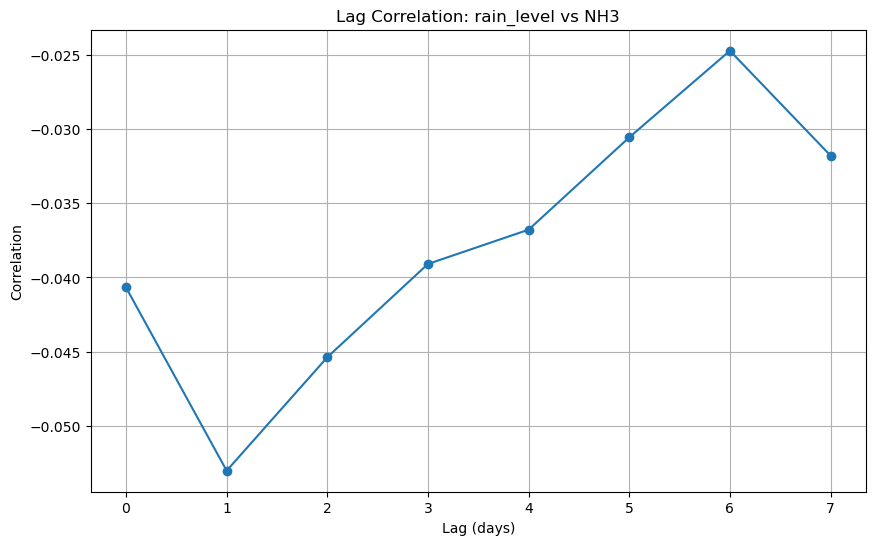

Correlation between rain_level and TP: 0.0549
Maximum lag correlation: 0.0549 at lag 0 days


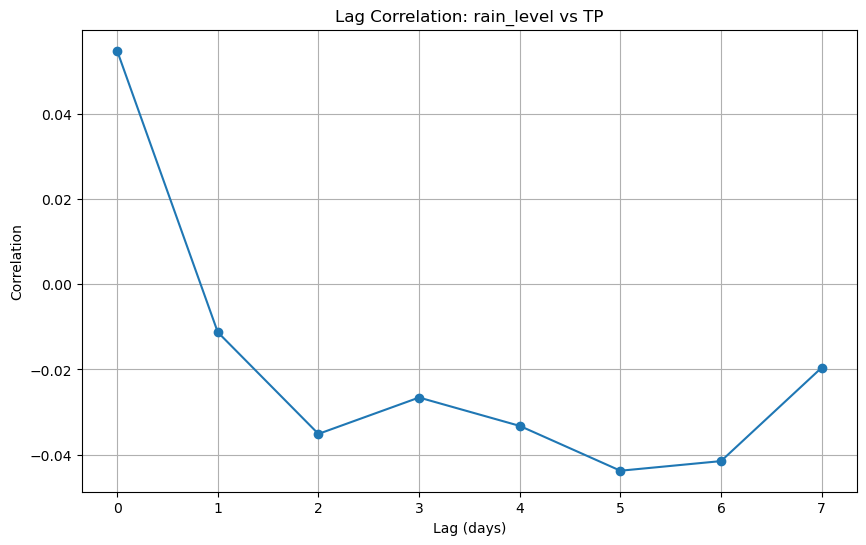

Correlation between rain_level and TN: -0.1511
Maximum lag correlation: -0.1726 at lag 3 days


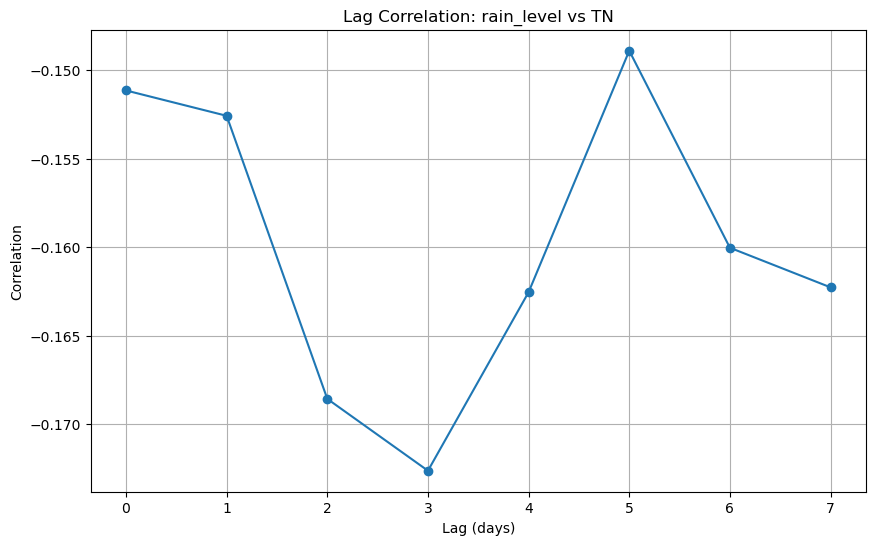



Correlation between continuous_rain and NH3: -0.0426
Maximum lag correlation: -0.0627 at lag 2 days


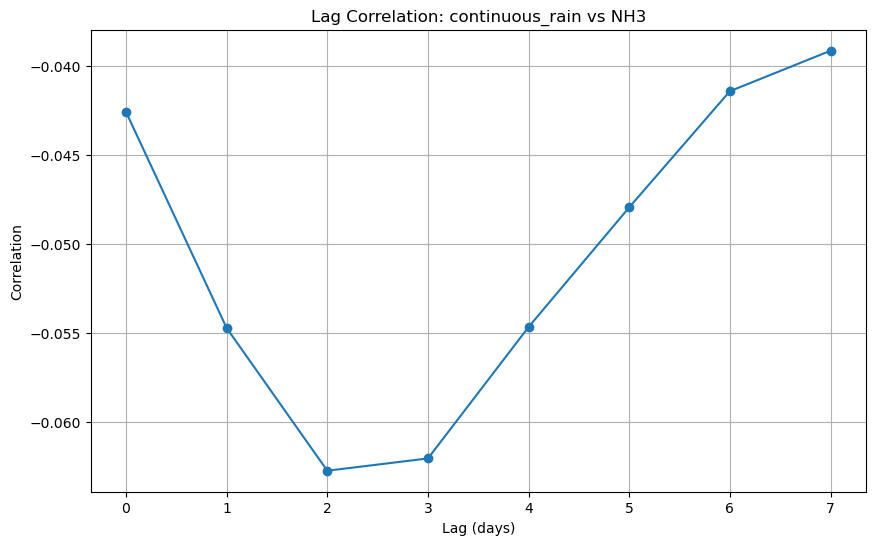

Correlation between continuous_rain and TP: 0.1920
Maximum lag correlation: 0.1920 at lag 0 days


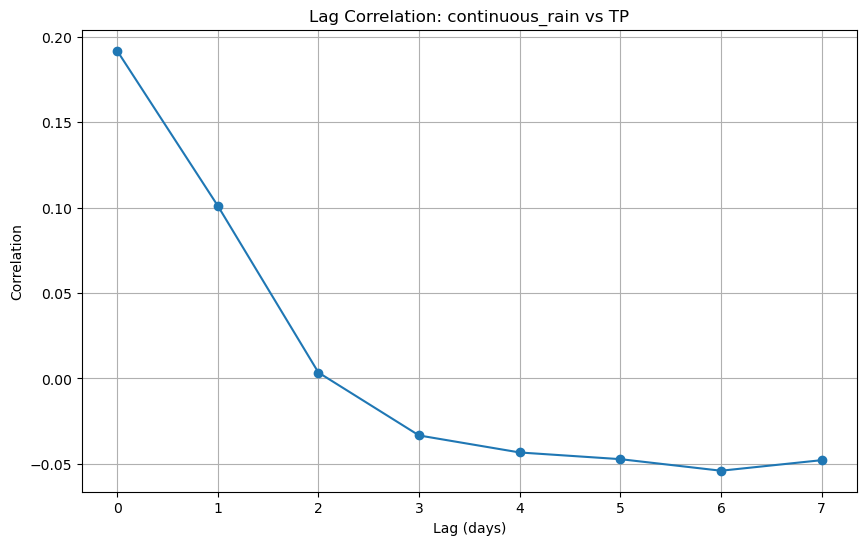

Correlation between continuous_rain and TN: -0.1949
Maximum lag correlation: -0.2278 at lag 4 days


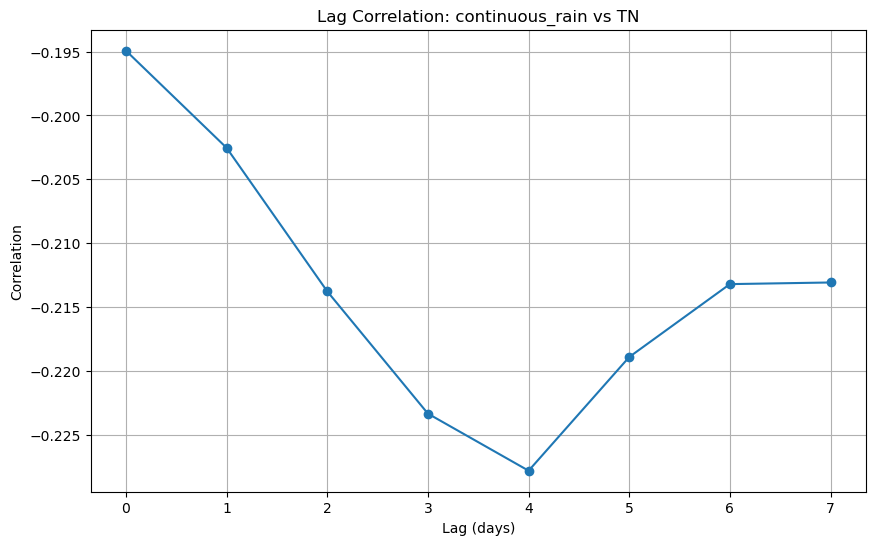

In [7]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

# 读取CSV文件
df = pd.read_csv('/root/Download/AlgaeBloomForecast/merged_data.csv', parse_dates=['date'])

# 定义降雨等级
rain_levels = {
    '暴雨': 5,
    '大雨': 4,
    '中雨': 3,
    '小雨': 2,
    '阵雨': 1,
    '雨': 1,
    '雷阵雨': 1
}

# 量化降雨水平
def quantify_rain(weather):
    for rain_type, level in rain_levels.items():
        if rain_type in weather:
            return level
    return 0

df['rain_level'] = df['weather'].apply(quantify_rain)

# 计算持续降雨天数
df['continuous_rain'] = df['rain_level'].rolling(window=3, min_periods=1).sum()

# 计算相关性
def calculate_correlation(x, y):
    return stats.pearsonr(x, y)[0]

# 计算滞后相关性
def lag_correlation(x, y, max_lag=7):
    correlations = []
    for lag in range(max_lag + 1):
        correlation = calculate_correlation(x[lag:], y[:-lag] if lag > 0 else y)
        correlations.append(correlation)
    return correlations

# 分析相关性和滞后相关性
parameters = ['NH3', 'TP', 'TN']
rain_types = ['rain_level', 'continuous_rain']

for rain_type in rain_types:
    for param in parameters:
        corr = calculate_correlation(df[rain_type], df[param])
        print(f"Correlation between {rain_type} and {param}: {corr:.4f}")
        
        lag_corrs = lag_correlation(df[rain_type], df[param])
        max_lag = np.argmax(np.abs(lag_corrs))
        print(f"Maximum lag correlation: {lag_corrs[max_lag]:.4f} at lag {max_lag} days")
        
        plt.figure(figsize=(10, 6))
        plt.plot(range(len(lag_corrs)), lag_corrs, marker='o')
        plt.title(f"Lag Correlation: {rain_type} vs {param}")
        plt.xlabel("Lag (days)")
        plt.ylabel("Correlation")
        plt.grid(True)
        plt.show()
        
    print("\n")